# College Essay Prompt Clustering

The goal of this program is to use nlp to eventually cluster college essay prompts from different colleges. Given that there are hundreds of prompts, the program will need to perform unsupervised clustering.

## Importing various modules

nltk is a very useful module for nlp.


In [185]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk

import numpy as np
# import torch
import matplotlib.pyplot as plt

import random
import math


import sklearn

# TRY THIS OUT
# https://github.com/nlptown/nlp-notebooks/blob/master/Simple%20Sentence%20Similarity.ipynb


from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk.download('punkt')
# nltk.download("stopwords")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [186]:
import requests

# link = "https://www.collegevine.com/schools/hub/overall/sheet"

link = "https://www.collegevine.com/schools/hub/data/static"

# avoid printing f.text; Large file
f = requests.get(link)


import re

university_list = re.findall("\"rankings\":.+?\"bucket\":\"(\d*)\",\"key\":\"overall\".+?\"slug\":\"(.+?)\"", f.text)


print(university_list[0])



('305', 'abilene-christian-university')


In [187]:
university_list = sorted(university_list, key = lambda pair: int(pair[0]))

gap = 0

for x in range(len(university_list)):
    university_list[x] = [int(university_list[x][0]), university_list[x][1]]
    if x+1 != int(university_list[x][0]) - gap:
        gap += 1
        print(university_list[x-1:x+1])

print(len(sorted(university_list, key = lambda pair: pair[0])))

top_400 = university_list[0:400]

[[287, 'bryant-university'], [289, 'milwaukee-school-of-engineering-msoe']]
[[403, 'ohio-wesleyan-university'], [405, 'brigham-young-university-hawaii']]
[[647, 'university-of-indianapolis'], [649, 'franklin-college']]
[[676, 'st-edward-s-university'], [678, 'high-point-university']]
[[682, 'pennsylvania-state-university-penn-state-harrisburg'], [684, 'hastings-college']]
[[799, 'university-of-nebraska-omaha-uno'], [801, 'university-of-toledo']]
[[852, 'rocky-mountain-college-rmc'], [854, 'hardin-simmons-university']]
[[863, 'the-university-of-texas-rio-grande-valley'], [865, 'mount-carmel-college-of-nursing']]
[[867, 'johnson-c-smith-university'], [869, 'spring-arbor-university']]
[[1053, 'tabor-college'], [1055, 'wells-college']]
[[1064, 'hope-international-university'], [1066, 'university-of-northwestern-st-paul']]
[[1190, 'humboldt-state-university-hsu'], [1193, 'methodist-university']]
[[1193, 'methodist-university'], [1194, 'northern-state-university']]
[[1263, 'north-central-uni

In [188]:
# get links for all schools

college_links = []

for school in top_400:
    name = school[1]
    college_links.append("https://www.collegevine.com/schools/" 
                            + name.replace(" ", "-") 
                            +  "/essay-prompts")

print(college_links[0])

https://www.collegevine.com/schools/stanford-university/essay-prompts


In [189]:
# obtain word bag

def get_bag(docs, word_list):
    out_list = []

    stop_words = set(stopwords.words("english") + ["etc", "'s", ""])

    for include in ["what", "where", "when", "why", "who"]:
        stop_words.discard(include)

    for doc in docs:
        filtered_list = []

        seperated_words = word_tokenize(doc[1])

        nonalpha_regex = re.compile('[^a-zA-Z]')

        for word in seperated_words:
            word = word.lower()

            # gets rid of non alphabetic characters
            word = nonalpha_regex.sub('', word)
            
            if word not in stop_words:
                if len(word) != 1:
                    filtered_list.append(word)
        
        tagged_list = nltk.pos_tag(filtered_list)
        
        lemmatizer = WordNetLemmatizer()
        lemmatized_list = []

        for word in tagged_list:
            pos = ""
            if word[1][0] == "J":
                pos = "a"
            elif word[1][0] == "N":
                pos = "n"
            elif word[1][0] == "V":
                pos = "v"
            elif word[1][0] == "R":
                pos = "r"
            else:
                continue

            lemmatized_list.append(lemmatizer.lemmatize(word[0], pos=pos))

        word_list += lemmatized_list
        out_list.append(lemmatized_list)
        
    return out_list, word_list

In [190]:
# access links and create general word bag


# currently trying to use list instead of dictionary to store prompts and their corresponding index
allprompts = []
prompt_matrix = []
prompt_corpus = []
numPrompts = []

potential_issues = []
index = 0
prompts = []
has_common_app = False
word_list = []

for link_index in range(len(college_links)):
    has_common_app = False
    link = college_links[link_index]
    f = requests.get(link)

    noprompts = re.search("<h2>", f.text)

    if not bool(noprompts):
        prompts = re.findall("<h3 class='mt-2'>(.+?)</h3>[\S\s]+?<p>(.+?)</p>", f.text)
        select_prompts = re.findall("</h5>\s<p>\s<p>(.+?)</p>", f.text)

        if prompts == []:
            potential_issues.append(link)
            continue

        if prompts[-1][0] == "Common App Personal Essay":
            has_common_app = True
            prompts = prompts[:-1]
            select_prompts = select_prompts[:-7]

        if select_prompts != []:
            i = 0
            while i < len(prompts):
                if "Select-A-Prompt" in prompts[i][0]:
                    del prompts[i]
                else:
                    i += 1

            if has_common_app:
                for x in select_prompts:
                    prompts.append(("Select-A-Prompt", x))

        numPrompts.append(len(prompts))

        # checks again, but now for schools with only common app essay
        if prompts == []:
            continue
        
        # prompts is a list of prompts for the current school.
        # each prompt is in a tuple with their title first and then the prompt
        allprompts.append([link_index, prompts])


        prompts, word_list = get_bag(prompts, word_list)

        for x in prompts:
            prompt_corpus.append(" ".join(x))
        
        
        for j in range(len(prompts)):
            prompt_matrix.append([index, j] + prompts[j])
        
        index += 1

In [191]:
# prompt_np_array = np.array(prompt_matrix)

print(prompt_matrix[0])
# print(prompt_corpus[0:10])
# print(prompt_np_array.shape)

# print(len(prompt_corpus))

[0, 0, 'stanford', 'community', 'deeply', 'curious', 'driven', 'learn', 'classroom', 'reflect', 'idea', 'experience', 'make', 'genuinely', 'excited', 'learning']


In [192]:
len(potential_issues)

print(potential_issues)

[]


In [234]:
print(allprompts[0:10])

[[0, [('Intellectual Passion Short Response', 'The Stanford community is deeply curious and driven to learn in and out of the classroom. Reflect on an idea or experience that makes you genuinely excited about learning.*'), ('Roommate Short Response', "Virtually all of Stanford's undergraduates live on campus. Write a note to your future roommate that reveals something about you or that will help your roommate – and us – get to know you better.*"), ('Share Something Meaningful Short Response', 'Tell us about something that is meaningful to you and why.*'), ('Societal Challenge Short Response', 'What is the most significant challenge that society faces today?'), ('Summer Activities Short Response', 'How did you spend your last two summers?'), ('Historical Moment Short Response', 'What historical moment or event do you wish you could have witnessed?'), ('Extracurricular Short Response', 'Briefly elaborate on one of your extracurricular activities, a job you hold, or responsibilities you h

In [194]:
print(len(word_list), len(set(word_list)))

# print(word_list[0:100])

random.seed = 111

word_list = list(set(word_list))

random.shuffle(word_list)

print(word_list[0:100])

10619 2240
['instruction', 'lee', 'description', 'emphasis', 'leverage', 'firstyear', 'interact', 'smu', 'accommodate', 'beloit', 'storytelling', 'clara', 'vt', 'contributions', 'conduct', 'tie', 'priority', 'responsible', 'garner', 'expulsion', 'kamkwamba', 'guilty', 'meet', 'aspera', 'fulltime', 'disparate', 'straight', 'tennis', 'strengths', 'second', 'better', 'binge', 'state', 'special', 'wesleyan', 'flexibility', 'explore', 'form', 'submit', 'norm', 'electrical', 'shortlived', 'lehigh', 'page', 'depend', 'entry', 'critic', 'texts', 'systemic', 'impacted', 'deepen', 'enable', 'equation', 'naturalize', 'offer', 'observe', 'llc', 'exemplary', 'outcomes', 'rochester', 'legend', 'choice', 'clear', 'keep', 'applicable', 'los', 'movement', 'lecture', 'ii', 'humancentered', 'christ', 'firstgeneration', 'checkboxes', 'interrelate', 'involve', 'exemplify', 'real', 'charlotte', 'york', 'talent', 'author', 'ted', 'always', 'identities', 'johnson', 'enter', 'share', 'accessible', 'hillsdale',

In [195]:
for i in range(len(top_400)):
    if i == 384:
        print(top_400[i])

[386, 'birmingham-southern-college-bsc']


In [196]:
# alltitles = []

# for link in college_links:
#     f = requests.get(link)

#     titles = re.findall("<h3 class='mt-2'>(.+?)</h3>", f.text)
#     alltitles += titles

# alltitles = set(alltitles)

# print(len(alltitles))


In [197]:
# print(list(alltitles)[0:10])

In [235]:
def indToDict(index):
    numPrompts = []
    for prompts in allprompts:
        numPrompts.append(len(prompts[1]))
    
    total = 0
    for x in range(len(numPrompts)):
        curr = numPrompts[x]

        if (total + curr) > index:
            ind = index - total
            return (x, ind)
        
        total += curr


# indToDict(9)

(1, 1)

In [199]:
# using sklearn tf-idf

vec = TfidfVectorizer(stop_words='english')

# print(prompt_np_array)

tfidf_matrix = vec.fit_transform(prompt_corpus)

# print("Feature Names n",vec.get_feature_names_out())
# print("Sparse Matrix n",matrix.shape,"n",matrix.toarray())

tfidf_shape = tfidf_matrix.shape
print(tfidf_shape)

tfidf_matrix_indexed = np.hstack((np.arange(tfidf_shape[0])[:, None], tfidf_matrix.toarray()))


print(tfidf_matrix_indexed)
# print(type(tfidf_matrix.toarray()))


(728, 2157)
[[  0.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]
 [  2.   0.   0. ...   0.   0.   0.]
 ...
 [725.   0.   0. ...   0.   0.   0.]
 [726.   0.   0. ...   0.   0.   0.]
 [727.   0.   0. ...   0.   0.   0.]]


In [200]:
# turn prompts into vectors
# stores number of docs with word w

# word_freq_matrix = []

# word_doc_freq = dict(zip(word_list, [0 for x in range(len(word_list))]))

# for prompt_ind in range(len(prompt_matrix)):
#     curr_freq = dict(zip(word_list, [0 for x in range(len(word_list))]))
    
#     # word_counted = False
#     # num_words = len(prompt_matrix[prompt_ind][2:])

#     for word in prompt_matrix[prompt_ind][2:]:
#         if curr_freq[word] == 0:
#             word_doc_freq[word] += 1
            
#         curr_freq[word] += 1
    
#     # prompt_matrix[prompt_ind] = prompt_matrix[prompt_ind][0:2] + list(curr_freq.values())
#     if sum(curr_freq.values()) <= 1:
#         print(prompt_matrix[prompt_ind][0:2])
#     word_freq_matrix.append(list(curr_freq.values()))

# print(word_doc_freq)


In [201]:
allprompts[12][1][1]

print(set(stopwords.words("english")))

{'an', "wouldn't", 'me', 'during', 'that', 'again', 'mustn', 'myself', 'themselves', 'wasn', 'a', 'himself', 'out', 'other', "mustn't", 'herself', "hadn't", 'doing', 'through', "didn't", 'all', 'their', 'if', 'only', 'where', 'am', 'any', 'above', 'whom', 'couldn', "you'll", "weren't", 'was', "should've", 'hasn', 'same', 'she', 'ours', 'has', 'below', 'isn', 'both', 'hadn', "it's", "shan't", 'it', 'few', 'yourselves', 'some', 'hers', 'further', 'don', 'didn', 'nor', 'won', 'we', 'are', "that'll", 'and', "needn't", 'once', 'were', 'up', 'about', 'just', "aren't", "couldn't", 'had', "wasn't", 'yours', 'who', 'do', 'into', "won't", 'does', "hasn't", 'i', 'from', 'over', 'ourselves', 'of', "doesn't", 'our', "you've", 'there', 'not', 'y', 'off', 'o', "she's", "shouldn't", 'more', 'with', 'what', 'no', 'these', 'under', 'then', 'wouldn', "mightn't", 'yourself', 'your', 'after', 'this', 'be', 'such', 'is', 'than', 'aren', 'weren', 'here', 'been', 'as', 'before', 'haven', 'most', 'until', 'you

In [202]:
print(max(word_freq_matrix[8]))

3


In [203]:
# tf-idf from scratch

# prompt_vectors = []

# for vector_ind in range(len(word_freq_matrix)):
#     tf_idf_vector = []

#     freq_ind = 0
#     for word_freq in word_freq_matrix[vector_ind]:
#         if word_freq > 0:
#             tf = word_freq / sum(word_freq_matrix[vector_ind])

#             if (tf > 1):
#                 print(vector_ind)
#                 print(word_freq, sum(word_freq_matrix[vector_ind]))
#             # print(len(word_list))
#             # print(len(word_freq_matrix[vector_ind]))

#             # look into idf...
#             # https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558
            
#             idf = math.log(len(word_freq_matrix) / word_doc_freq[word_list[freq_ind]])
#             tf_idf_vector.append(tf * idf)

#             if (tf*idf > 1):
#                 print(tf*idf)
#                 print(len(word_freq_matrix), word_doc_freq[word_list[freq_ind]])
#         else:
#             tf_idf_vector.append(0)
#         freq_ind += 1
    
#     prompt_vectors.append(prompt_matrix[vector_ind][0:2] + tf_idf_vector)


In [204]:
max(prompt_vectors[2][2:])

1.2725707753189681

In [205]:
print(max([max(prompt_vectors[x][2:]) for x in range(len(prompt_vectors))]))
# print(prompt_matrix)

6.590301048196686


In [250]:
# # pytorch PCA
# prompt_tensor = torch.tensor(prompt_matrix, dtype=torch.float32)

# print(prompt_tensor.shape)

# torch.manual_seed(333)
# U, S, V = torch.pca_lowrank(prompt_tensor[:,2:], q=None, center=True, niter=3)

# pca_axes = torch.matmul(prompt_tensor[:,2:], V[:, :7])

# # sklearn PCA

from sklearn.decomposition import PCA
prompt_np_array = np.asarray(prompt_vectors)

print(prompt_np_array.shape)

pca = PCA(n_components=5)

# pca.fit(prompt_np)



# pca_data = pca.fit_transform(prompt_np_array[:,2:])
pca_data = pca.fit_transform(tfidf_matrix_indexed[:,1:])

pca_data = np.hstack((np.arange(pca_data.shape[0])[:, None], pca_data))

# print(pca_data[0:100])

# print(pca.score(pca_data))

pca_data[0,]

(728, 2242)


array([ 0.        , -0.0027957 , -0.13339342, -0.10544197,  0.03887054,
       -0.04330314])

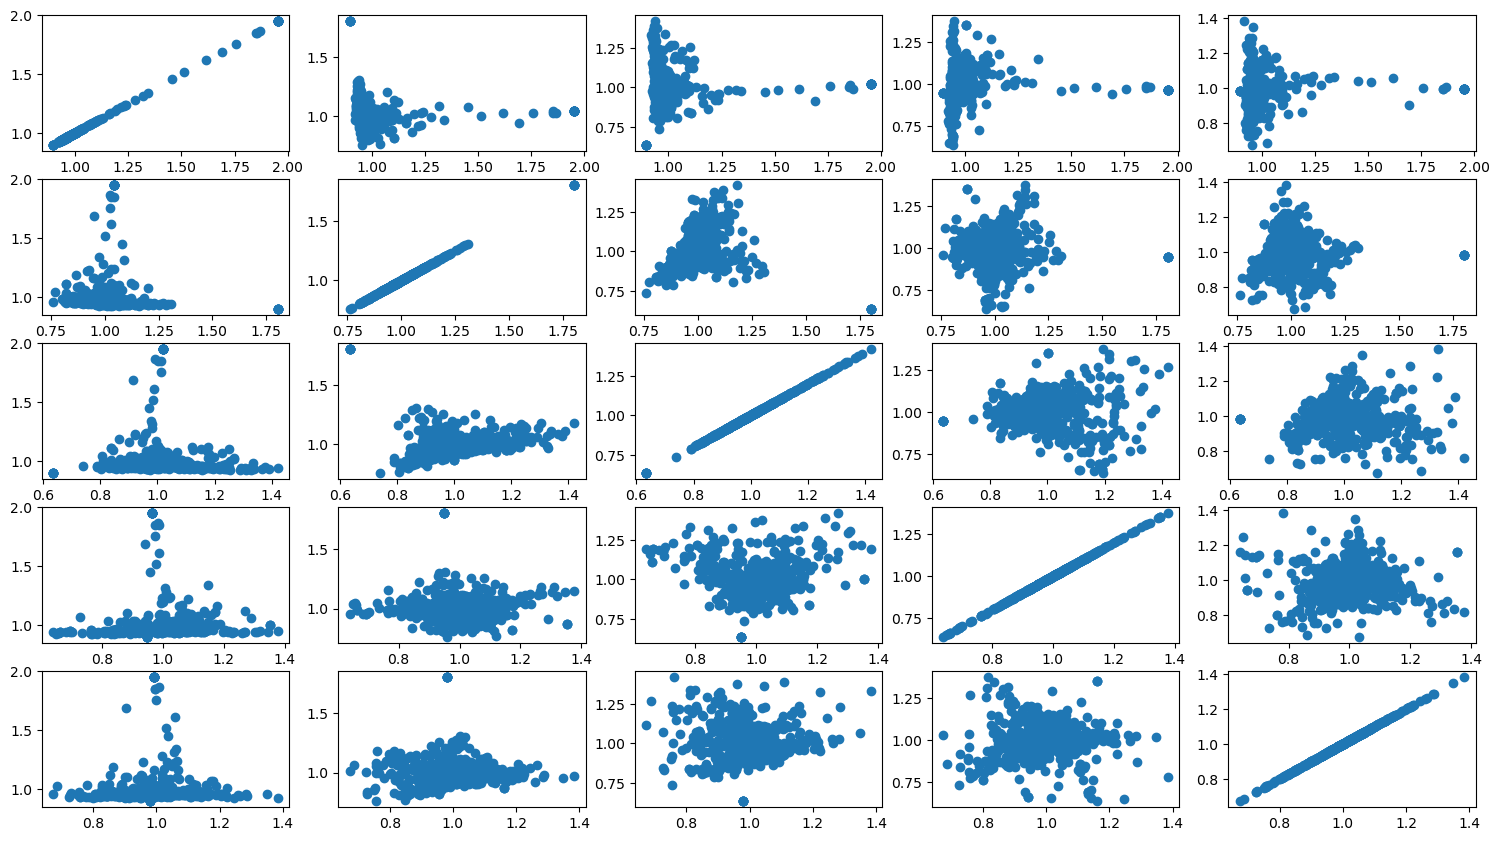

In [254]:
# print(pca_axes[...,0])
# print(max(pca_axes[:,0]))


# combo plot
num_comps = pca_data.shape[1]-1

fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(1, num_comps+1):
    for j in range(1, num_comps+1):
        axs[i-1][j-1].scatter(pca_data[:,i]+1, pca_data[:,j]+1)

# plt.setp(axs, xlim=[0.977,1.00], ylim=[0.977,1.00])

plt.show()

# interesting note: almost all the plots have a central clump and then one or more very pronounced arms
# need to consider whether PCA is meaningful for nlp clustering


# # single plot

# fig = plt.figure(figsize=(20,20))
# plt.scatter(pca_axes[:,0], pca_axes[:,1], s=20)

# fig.set_dpi(100)

In [208]:
# k means clustering from scratch
# 2D ONLY

# import random

# def find_distances(xvals, yvals, centroids):
#     clusters = [[] for x in range(len(centroids))]

#     for i in range(len(xvals)):
#         curr_point = [xvals[i], yvals[i]]

#         # should be large enough given that words will rarely 
#         #   occur more than even 20 times in one prompt
#         min_dist = 100000
#         min_ind = -1
#         for j in range(len(centroids)):
#             # print(centroids[j])
#             curr_dist = sum(abs(centroids[j] - curr_point)) ** 0.5
#             # print(curr_dist)
#             if curr_dist < min_dist:
#                 min_dist = curr_dist
#                 min_ind = j
        
#         # print(min_ind)
#         clusters[min_ind].append(curr_point)

#     return clusters


# def k_means(xvals, yvals, k):
#     centroids = []

#     random.seed(333)

#     for center_num in range(k):
#         index = random.randrange(0, len(xvals))
#         coordinate = np.asarray([xvals[index], yvals[index]])
#         centroids.append(coordinate)
    
#     # print(centroids)
#     equal_means = 0
#     clusters = []

#     while equal_means < k:
#         clusters = find_distances(xvals, yvals, centroids)
#         # print(len(clusters))
#         for i in range(k):
#             mean = sum(np.asarray(clusters[i])) / len(clusters[i])
#             # print(mean)
#             if (mean[0] != centroids[i][0]) and (mean[1] != centroids[i][1]):
#                 centroids[i] = mean
#             else:
#                 equal_means += 1
    
#     return clusters


In [295]:
# k-means for any dim, points is list of vectors in n-dim

def select_init(points, k, labels):
    random.seed = (333)

    dist_weights = []
    centroids = []

    centroids.append(np.asarray(random.choice(points)))

    while len(centroids) < k:
        dist_weights = find_distances(points, centroids, labels)
        # print()
        centroids.append(np.asarray(random.choices(points, weights=dist_weights)[0]))
    
    # print(centroids)
    return centroids


def find_distances(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]
    closest_dists = []
    # print(centroids)

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            # print(centroids[j][labels:])
            # print(curr_dist, j)
            if curr_dist < min_dist:
                min_dist = curr_dist
        
        closest_dists.append(min_dist)
        # print(min_ind)
        
    return closest_dists


def find_clusters(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            if curr_dist < min_dist:
                min_dist = curr_dist
                min_ind = j
        
        # print(min_ind)
        clusters[min_ind].append(curr_point)

    return clusters


def k_means(points, k, labels = 0):

    # random.seed(133)
    print(labels)

    centroids = select_init(points, k, labels)

    # centroids = random.sample(points, k)

    for center_num in range(k):
        centroids[center_num] = np.asarray(centroids[center_num])
    
    # print(centroids)
    equal_means = 0
    clusters = []

    while equal_means < k:
        clusters = find_clusters(points, centroids, labels)
        # print(clusters[0])
        for i in range(k):
            # mean = [0 for x in range(len(points) - labels)]

            # for point_ind in range(1, len(clusters[i])):
            #     mean[point_ind] += clusters[i][point_ind] / len(clusters[i])

            mean = sum(np.asarray(clusters[i])) / len(clusters[i])

            dim = labels
            curr_equal_means = True
            while (dim < len(points[0])) and curr_equal_means:
                if (mean[dim] != centroids[i][dim]):
                    centroids[i] = mean
                    curr_equal_means = False
                dim += 1
            
            if dim == len(points[0]):
                equal_means += 1
    
    return clusters

In [299]:
# print([[pca_data[:,1][i], pca_data[:,2][i]] for i in range(len(pca_data[:,1]))])
# print([list(pca_data[i,0:3]) for i in range(len(pca_data[:,1]))])

1
47


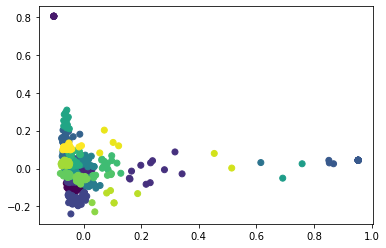

In [300]:
# pca_points = [[pca_data[:,1][i], pca_data[:,2][i]] for i in range(len(pca_data[:,1]))]

pca_points = [list(pca_data[i,0:3]) for i in range(len(pca_data[:,1]))]

# print(pca_points)
num_clusters = 30

pca_clusters = k_means(pca_points, num_clusters, labels = 1)

# EVERYTHING IS IN ONE CLUSTER AHHHHH
print(len(pca_clusters[0]))

pca_clusters_graph = []

for c in range(len(pca_clusters)):
    for x in pca_clusters[c]:
        pca_clusters_graph.append(x + [c])

pca_clusters_graph = np.asarray(pca_clusters_graph)

plt.scatter(pca_clusters_graph[:,1], pca_clusters_graph[:,2], c = pca_clusters_graph[:,3])

In [303]:
n = 3
for point in pca_clusters[n]:
    r, c = indToDict(point[0])

    print(r, c)

    print(allprompts[int(r)][int(c)])

7 7.0


IndexError: list index out of range

In [212]:
all_clusters = k_means(tfidf_matrix.toarray(), 30, labels = 0)

for x in all_clusters:
    print(len(x))

35
54
34
26
42
14
15
12
39
9
19
42
4
19
43
56
20
23
5
36
27
18
8
2
26
45
10
24
9
12


In [ ]:
n = 48
for x in all_clusters[n:n+1]:
    print(len(x))

    for i in range(0, len(x), 1):
        # school_ind = x[i][0]
        # prompt_ind = x[i][1]
        print(top_400[allprompts[school_ind][0]], allprompts[school_ind][1][prompt_ind])

# current issue: the vectors are basically just clustering based on their order in rankings
# solutions: 1) randomize word_list order
#            2) uhhhhh why does it still group them by order wtf


13


TypeError: list indices must be integers or slices, not numpy.float64

In [213]:
import hdbscan

cluster_obj = hdbscan.HDBSCAN(min_cluster_size=10)

cluster_obj.fit(tfidf_matrix.toarray())

HDBSCAN(min_cluster_size=10)

In [214]:
print(sum(cluster_obj.labels_))

-595


C:\Users\VChen2022\Miniconda3\envs\scikit\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\VChen2022\Miniconda3\envs\scikit\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


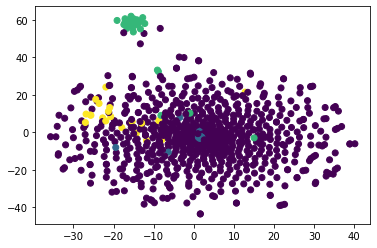

In [215]:
# cluster_obj.probabilities_

# cluster_obj.single_linkage_tree_.plot()

np.random.seed = 222

projection = sklearn.manifold.TSNE().fit_transform(prompt_np_array[:,2:])
plt.scatter(*projection.T, c=cluster_obj.labels_)

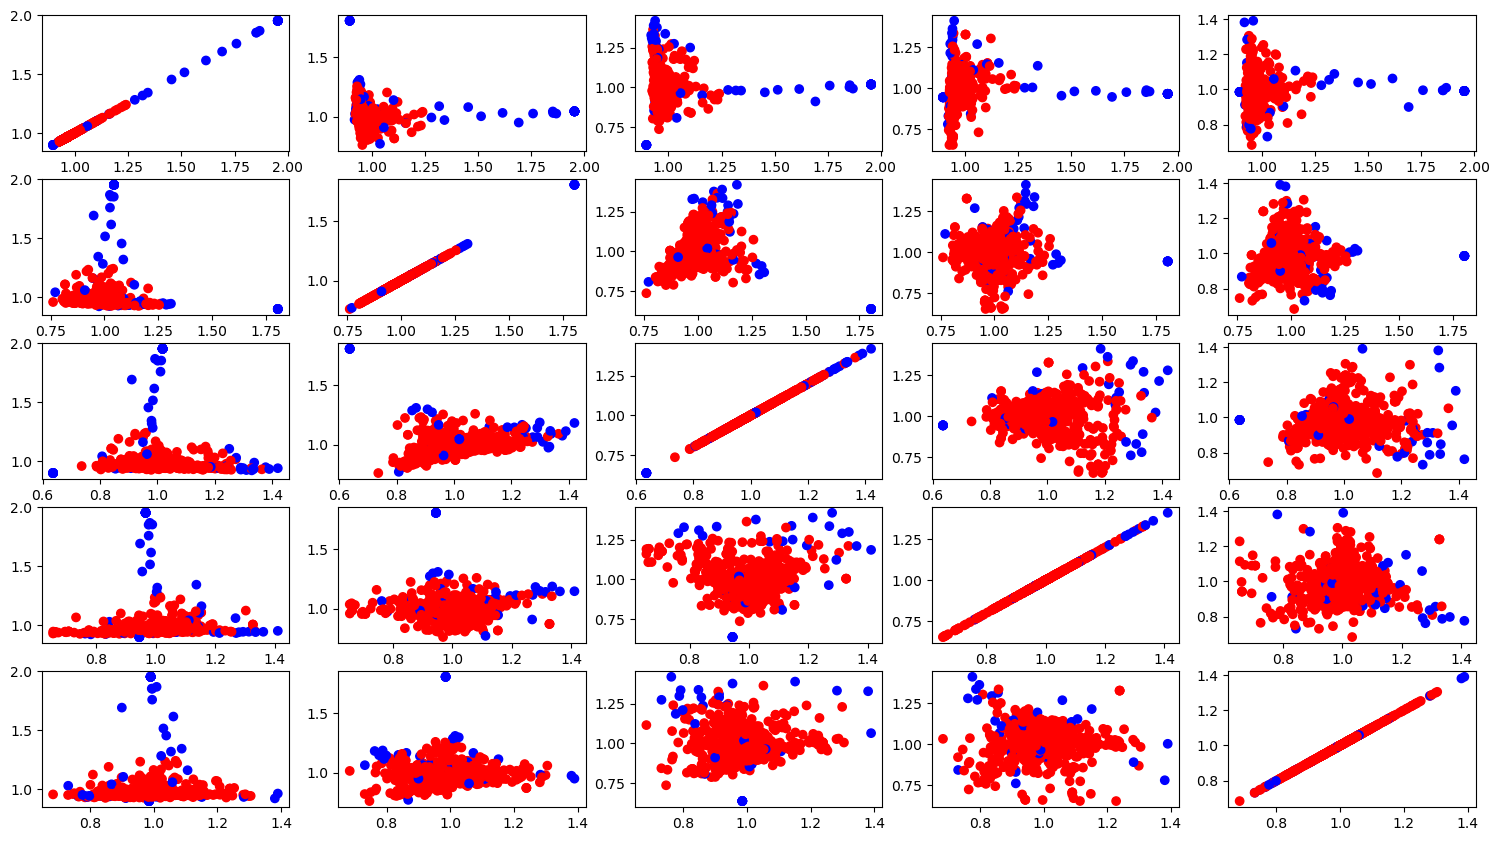

In [216]:
# plt.scatter(pca_clusters_graph[:,0], pca_clusters_graph[:,1], c = cluster_obj.labels_)


num_comps = 5

fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(0, num_comps):
    for j in range(0, num_comps):
        axs[i][j].scatter(pca_data[:,i]+1, pca_data[:,j]+1, c = ["red" if x < 0 else "blue" for x in cluster_obj.labels_])

In [ ]:
# to-do 
# [X] conda env export > environment.yml 
# [?] incorporate select-a-prompts
# [?] check for weird symbols, i.e. "&amp"
# [] figure out issue with multi paragraph prompts
# [*] use nltk to process prompts
# [*] look into tf-idf
# [X] download matplotlib on school computer
# [*] clustering
#  - - [x] k-means based on euclidean dist
#  - - [] k-means based on cosine similarity?
#  - - [] hierarchical
# [X] commit and push yml file to remote
# [?] create list translating between ranking and name, basically watch out for 288 and maybe 404
#  - - [] use array instead of dictionary for allprompts? if looking for original, just use index...
# [*] try larger number of clusters (100?)
# [] look into ML algs for unsupervised clustering, maybe NN?
# [] filter words?
# [] generalize words, i.e. proper nouns are roughly the same idea
# [] favor specific words
# [] consider words in context, not just in isolation
# [] create general forms for prompt archetypes


# https://towardsdatascience.com/different-techniques-to-represent-words-as-vectors-word-embeddings-3e4b9ab7ceb4
# https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
# https://towardsdatascience.com/a-friendly-introduction-to-text-clustering-fa996bcefd04